## Original Dataset

In [1]:
import pandas as pd
import os

# Folder path
dataset_path = '../data/original-datasets'

# Required columns
required_columns = ['CC', 'LCOM5', 'WMC', 'CBO', 'RFC', 'DIT',	'NOC', 'LOC', 'NPM', 'isExistBug']

# List to collect all valid DataFrames
df_list = []

# Iterate through all CSV files in the folder
for filename in os.listdir(dataset_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(dataset_path, filename)
        try:
            df = pd.read_csv(file_path)

            # Check if all required columns are present
            if all(col in df.columns for col in required_columns):
                # Extract project name from the filename (without extension)
                project_name = os.path.splitext(filename)[0]
                df = df[required_columns].copy()  # Keep only required columns
                df['project'] = project_name      # Add project name as a column
                df_list.append(df)
            else:
                print(f"Missing required columns: {filename}")
        except Exception as e:
            print(f"Error while reading file: {filename} | {e}")

# If at least one file was loaded successfully, concatenate them
if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)
    print(f"Total number of rows: {len(combined_df)}")
    print(combined_df.head())
else:
    print("No valid file found. Please check the files and column names.")


Total number of rows: 37630
    CC  LCOM5  WMC  CBO  RFC  DIT  NOC  LOC  NPM  isExistBug  \
0  0.0      6   18    4   20    0    0  243   13           0   
1  0.0      0    5    1    5    0    0   71    5           0   
2  0.0      1   16    6   11    0    0   59    3           0   
3  0.0      2   14    3   11    0    2  308   10           0   
4  0.0      0    2    0    2    0    0   27    2           0   

                 project  
0  BugPrediction_Eclipse  
1  BugPrediction_Eclipse  
2  BugPrediction_Eclipse  
3  BugPrediction_Eclipse  
4  BugPrediction_Eclipse  


In [4]:
combined_df.to_csv('final_data.csv')

In [2]:
# Project-Level Bug Statistics Summary Table

from tabulate import tabulate

# Create bug statistics table per project
bug_summary = combined_df.groupby('project').agg(
    total_instances=('isExistBug', 'count'),
    bug_instances=('isExistBug', 'sum')
)

# Calculate bug rate as a percentage
bug_summary['bug_rate_percent'] = 100 * bug_summary['bug_instances'] / bug_summary['total_instances']

# Round the percentage
bug_summary['bug_rate_percent'] = bug_summary['bug_rate_percent'].round(2)

# Sort by bug rate
bug_summary = bug_summary.sort_values('bug_rate_percent', ascending=False).reset_index()

# Print the table
print(tabulate(bug_summary, headers='keys', tablefmt='fancy_grid', showindex=False))


╒══════════════════════════╤═══════════════════╤═════════════════╤════════════════════╕
│ project                  │   total_instances │   bug_instances │   bug_rate_percent │
╞══════════════════════════╪═══════════════════╪═════════════════╪════════════════════╡
│ Promise_xalan27          │               909 │             898 │              98.79 │
├──────────────────────────┼───────────────────┼─────────────────┼────────────────────┤
│ Promise_log4j            │               205 │             189 │              92.2  │
├──────────────────────────┼───────────────────┼─────────────────┼────────────────────┤
│ Promise_xerces           │               546 │             396 │              72.53 │
├──────────────────────────┼───────────────────┼─────────────────┼────────────────────┤
│ Promise_poi30            │               442 │             281 │              63.57 │
├──────────────────────────┼───────────────────┼─────────────────┼────────────────────┤
│ Promise_lucene24         │    

In [3]:
# Z-Score Analysis of Bug Rates Across Projects

from scipy.stats import zscore
from tabulate import tabulate

# Calculate Z-score
bug_summary['z_score'] = zscore(bug_summary['bug_rate_percent'])

# Select necessary columns and sort by Z-Score
zscore_table = bug_summary[['project', 'bug_rate_percent', 'z_score']].sort_values(by='z_score', ascending=False)

# Print the table
print(tabulate(
    zscore_table,
    headers=['Project', 'Bug Rate (%)', 'Z-Score'],
    tablefmt='fancy_grid',
    showindex=False,
    floatfmt=".2f"
))


╒══════════════════════════╤════════════════╤═══════════╕
│ Project                  │   Bug Rate (%) │   Z-Score │
╞══════════════════════════╪════════════════╪═══════════╡
│ Promise_xalan27          │          98.79 │      2.92 │
├──────────────────────────┼────────────────┼───────────┤
│ Promise_log4j            │          92.20 │      2.66 │
├──────────────────────────┼────────────────┼───────────┤
│ Promise_xerces           │          72.53 │      1.88 │
├──────────────────────────┼────────────────┼───────────┤
│ Promise_poi30            │          63.57 │      1.52 │
├──────────────────────────┼────────────────┼───────────┤
│ Promise_lucene24         │          59.88 │      1.37 │
├──────────────────────────┼────────────────┼───────────┤
│ Promise_ckjm18           │          55.56 │      1.20 │
├──────────────────────────┼────────────────┼───────────┤
│ BugPrediction_Equinox    │          39.50 │      0.56 │
├──────────────────────────┼────────────────┼───────────┤
│ Promise_velo

In [4]:
# Outlier Projects Based on Bug Rate Z-Scores
from tabulate import tabulate

# 1. Filter out projects where the absolute z-score is greater than 2
outlier_projects_df = bug_summary[bug_summary['z_score'].abs() > 2][['project', 'bug_rate_percent', 'z_score']].copy()
outlier_projects = outlier_projects_df['project'].tolist()

# 2. Keep only the non-outlier projects
filtered_combined_df = combined_df[~combined_df['project'].isin(outlier_projects)].copy()

# 3. Summary of the filtering
print(f"Number of removed outlier projects: {len(outlier_projects)}")
print(f"Number of remaining projects: {filtered_combined_df['project'].nunique()}")
print(f"Total number of rows after filtering: {len(filtered_combined_df)}")

# 4. Show removed projects with reason (z-score)
print("Outlier Projects (|z-score| > 2):")
print(tabulate(
    outlier_projects_df.sort_values(by='z_score', ascending=False),
    headers=['Project', 'Bug Rate (%)', 'Z-Score'],
    tablefmt='fancy_grid',
    floatfmt=".2f",
    showindex=False
))

Number of removed outlier projects: 2
Number of remaining projects: 32
Total number of rows after filtering: 36516
Outlier Projects (|z-score| > 2):
╒═════════════════╤════════════════╤═══════════╕
│ Project         │   Bug Rate (%) │   Z-Score │
╞═════════════════╪════════════════╪═══════════╡
│ Promise_xalan27 │          98.79 │      2.92 │
├─────────────────┼────────────────┼───────────┤
│ Promise_log4j   │          92.20 │      2.66 │
╘═════════════════╧════════════════╧═══════════╛


In [5]:
# Listing All Project Names from CSV Files in a Directory
import os

# Folder path
dataset_path = "../data/original-datasets"

# Get CSV filenames and remove the .csv extension
project_names = [
    os.path.splitext(filename)[0]
    for filename in os.listdir(dataset_path)
    if filename.endswith(".csv")
]

# Print the list
print("Total number of projects:", len(project_names))
print("Project names:")
for name in project_names:
    print("-", name)


Total number of projects: 34
Project names:
- BugPrediction_Eclipse
- BugPrediction_Equinox
- BugPrediction_lucene
- BugPrediction_Mylyn
- BugPrediction_PDE
- Github_Android
- Github_antlr4
- Github_BroadleafCommerce
- Github_ceylon
- Github_Elasticsearch
- Github_hazelcast
- Github_JUnit
- Github_mapdb
- Github_mcMMO
- Github_mct17
- Github_Neo4j
- Github_Netty
- Github_orientdb
- Github_oryx
- Github_titan
- Promise_ant14
- Promise_camel16
- Promise_ckjm18
- Promise_forrest08
- Promise_ivy20
- Promise_jedit43
- Promise_log4j
- Promise_lucene24
- Promise_pbeans2
- Promise_poi30
- Promise_synapse12
- Promise_velocity16
- Promise_xalan27
- Promise_xerces


## Computation Dataset Complexity Metrics

In [6]:
# Batch Computation and Export of Dataset Complexity Metrics for Multiple Projects

import os
import pandas as pd
from problexity import ComplexityCalculator
from sklearn.preprocessing import LabelEncoder

# Input and output folder paths
input_folder = "../data/original-datasets/"
output_folder = "../data/originaldata-complexitymetrics/"

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Get all project names by removing .csv extension
project_names = [
    os.path.splitext(filename)[0]
    for filename in os.listdir(input_folder)
    if filename.endswith(".csv")
]

# Process each project
for project_name in project_names:
    input_file = os.path.join(input_folder, f"{project_name}.csv")
    output_file = os.path.join(output_folder, f"CM_{project_name}.csv")

    if not os.path.exists(output_file):
        print(f"Calculating metrics for {project_name}...")

        try:
            # Read dataset
            df = pd.read_csv(input_file)

            # Separate features and target
            X = df.drop(columns=["isExistBug"]).astype(float)
            y = LabelEncoder().fit_transform(df["isExistBug"])

            # Compute complexity metrics
            cc = ComplexityCalculator()
            cc.fit(X, y)
            report = cc.report()
            metrics = report["complexities"]
            metrics["score"] = report["score"]

            # Convert to DataFrame
            df_metrics = pd.DataFrame([metrics])
            df_metrics.insert(0, "project_name", project_name)

            # Save to CSV
            df_metrics.to_csv(output_file, index=False)
            print(f"{output_file} created successfully.")
        
        except Exception as e:
            print(f"Error processing {project_name}: {e}")
    
    else:
        print(f"{output_file} already exists. Skipping.")
        

Calculating metrics for BugPrediction_Eclipse...
../data/originaldata-complexitymetrics/CM_BugPrediction_Eclipse.csv created successfully.
Calculating metrics for BugPrediction_Equinox...
../data/originaldata-complexitymetrics/CM_BugPrediction_Equinox.csv created successfully.
Calculating metrics for BugPrediction_lucene...
../data/originaldata-complexitymetrics/CM_BugPrediction_lucene.csv created successfully.
Calculating metrics for BugPrediction_Mylyn...
../data/originaldata-complexitymetrics/CM_BugPrediction_Mylyn.csv created successfully.
Calculating metrics for BugPrediction_PDE...
../data/originaldata-complexitymetrics/CM_BugPrediction_PDE.csv created successfully.
Calculating metrics for Github_Android...
../data/originaldata-complexitymetrics/CM_Github_Android.csv created successfully.
Calculating metrics for Github_antlr4...
../data/originaldata-complexitymetrics/CM_Github_antlr4.csv created successfully.
Calculating metrics for Github_BroadleafCommerce...
../data/originaldat

C:\Users\ramaz\AppData\Roaming\Python\Python313\site-packages\problexity\classification\feature_based.py:45: RuntimeWarning: invalid value encountered in divide
  r_all = l/m
C:\Users\ramaz\AppData\Roaming\Python\Python313\site-packages\problexity\classification\feature_based.py:141: RuntimeWarning: invalid value encountered in divide
  return np.nanprod(f_overlap/f_range)


../data/originaldata-complexitymetrics/CM_Promise_ckjm18.csv created successfully.
Calculating metrics for Promise_forrest08...
../data/originaldata-complexitymetrics/CM_Promise_forrest08.csv created successfully.
Calculating metrics for Promise_ivy20...
../data/originaldata-complexitymetrics/CM_Promise_ivy20.csv created successfully.
Calculating metrics for Promise_jedit43...
../data/originaldata-complexitymetrics/CM_Promise_jedit43.csv created successfully.
Calculating metrics for Promise_log4j...
../data/originaldata-complexitymetrics/CM_Promise_log4j.csv created successfully.
Calculating metrics for Promise_lucene24...
../data/originaldata-complexitymetrics/CM_Promise_lucene24.csv created successfully.
Calculating metrics for Promise_pbeans2...
../data/originaldata-complexitymetrics/CM_Promise_pbeans2.csv created successfully.
Calculating metrics for Promise_poi30...
../data/originaldata-complexitymetrics/CM_Promise_poi30.csv created successfully.
Calculating metrics for Promise_sy

## Merge Complexity Metrics

In [7]:
# Merging Project-Level Complexity Metric Files into a Single CSV
import os
import pandas as pd

# Input folder and output file path
input_folder = "../data/originaldata-complexitymetrics/"
output_folder = "../data/results/originaldata-results/"
output_file = os.path.join(output_folder, "merged_complexity_metrics.csv")

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Initialize an empty list
df_list = []

# Read all CSV files in the input folder that start with "CM_"
for filename in os.listdir(input_folder):
    if filename.startswith("CM_") and filename.endswith(".csv"):
        filepath = os.path.join(input_folder, filename)
        df = pd.read_csv(filepath)
        df_list.append(df)

# Concatenate all dataframes
merged_df = pd.concat(df_list, ignore_index=True)

# Save the merged dataframe to CSV
merged_df.to_csv(output_file, index=False)
print(f"All complexity metrics merged into: {output_file}")


All complexity metrics merged into: ../data/results/originaldata-results/merged_complexity_metrics.csv


## Feature Selection Stability Metrics

In [9]:
# Automated Feature Selection and Stability Evaluation Across Multiple Projects
import os
import sys
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from skrebate import ReliefF
from sklearn.model_selection import StratifiedShuffleSplit
import random

# Add 'stability' module to path
sys.path.append(os.path.abspath('stability'))
import stability as st

# Folder configuration
dataset_folder = "../data/original-datasets"
output_dir = "../data/originaldata-fs-stability-metrics"
os.makedirs(output_dir, exist_ok=True)

# Feature and target definitions
features = ['CC', 'LCOM5', 'WMC', 'CBO', 'RFC', 'DIT', 'NOC', 'LOC', 'NPM']
target = 'isExistBug'

# Feature selection parameters
k = 3
n_iter = 30
random_state = None

# Helper function: convert feature selection results to binary matrix
def fs_result_to_binary_matrix(fs_result_list, all_features):
    return np.array([[1 if feat in selected else 0 for feat in all_features] for selected in fs_result_list])

# Process each CSV file
for filename in os.listdir(dataset_folder):
    if filename.endswith(".csv"):
        project_name = os.path.splitext(filename)[0]
        file_path = os.path.join(dataset_folder, filename)

        print(f"\nProcessing project: {project_name}")

        # 1. Load dataset
        df = pd.read_csv(file_path)
        X = df[features]
        y = LabelEncoder().fit_transform(df[target])

        splitter = StratifiedShuffleSplit(n_splits=n_iter, test_size=0.2, random_state=random_state)
        fs_results = {method: [] for method in ["Chi2", "MutualInfo", "ReliefF", "Lasso"]}

        # 2. Perform feature selection
        for _, (train_idx, _) in enumerate(splitter.split(X, y), start=1):
            X_sample = X.iloc[train_idx]
            y_sample = y[train_idx]

            # Chi2
            chi2_selector = SelectKBest(score_func=chi2, k=k)
            chi2_selector.fit(X_sample, y_sample)
            fs_results["Chi2"].append(X_sample.columns[chi2_selector.get_support()].tolist())

            # Mutual Info
            mi_selector = SelectKBest(score_func=mutual_info_classif, k=k)
            mi_selector.fit(X_sample, y_sample)
            fs_results["MutualInfo"].append(X_sample.columns[mi_selector.get_support()].tolist())

            # ReliefF
            relief_selector = ReliefF(n_features_to_select=k)
            relief_selector.fit(X_sample.values, y_sample)
            top_relief = relief_selector.top_features_[:k]
            fs_results["ReliefF"].append(X_sample.columns[top_relief].tolist())

            # Lasso
            lasso_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=random.randint(0, 9999))
            lasso_model.fit(X_sample, y_sample)
            lasso_features = X_sample.columns[lasso_model.coef_[0] != 0].tolist()
            fs_results["Lasso"].append(lasso_features[:k] if len(lasso_features) > k else lasso_features)

        # 3. Save selected features to CSV (if not already exists)
        for method, results in fs_results.items():
            out_path = f"{output_dir}/{project_name}_{method}_selected_features.csv"
            if not os.path.exists(out_path):
                df_method = pd.DataFrame(results)
                df_method.index = [f"Run_{i+1}" for i in range(n_iter)]
                df_method.columns = [f"Feature_{j+1}" for j in range(df_method.shape[1])]
                df_method.insert(0, "Project", project_name)
                df_method.to_csv(out_path, index_label="Run")
            else:
                print(f"Skipped existing file: {out_path}")

        # 4. Compute stability scores and save to CSV (if not already exists)
        stab_path = f"{output_dir}/{project_name}_feature_selection_stability.csv"
        if not os.path.exists(stab_path):
            stability_records = []
            for method in fs_results:
                Z = fs_result_to_binary_matrix(fs_results[method], features)
                stab = st.getVarianceofStability(Z)
                ci = st.confidenceIntervals(Z)
                stability_records.append({
                    "Project": project_name,
                    "Method": method,
                    "Stability": round(stab['stability'], 4),
                    "CI_Lower": round(ci['lower'], 4),
                    "CI_Upper": round(ci['upper'], 4)
                })
            df_stability = pd.DataFrame(stability_records)
            df_stability.to_csv(stab_path, index=False)
        else:
            print(f"Skipped existing stability file: {stab_path}")

print("\nAll projects processed. Feature selection results and stability scores are saved.")



Processing project: BugPrediction_Eclipse

Processing project: BugPrediction_Equinox

Processing project: BugPrediction_lucene

Processing project: BugPrediction_Mylyn

Processing project: BugPrediction_PDE

Processing project: Github_Android

Processing project: Github_antlr4

Processing project: Github_BroadleafCommerce

Processing project: Github_ceylon

Processing project: Github_Elasticsearch

Processing project: Github_hazelcast

Processing project: Github_JUnit

Processing project: Github_mapdb

Processing project: Github_mcMMO

Processing project: Github_mct17

Processing project: Github_Neo4j

Processing project: Github_Netty

Processing project: Github_orientdb

Processing project: Github_oryx

Processing project: Github_titan

Processing project: Promise_ant14

Processing project: Promise_camel16

Processing project: Promise_ckjm18

Processing project: Promise_forrest08

Processing project: Promise_ivy20

Processing project: Promise_jedit43

Processing project: Promise_log4

C:\Users\ramaz\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ramaz\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ramaz\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ramaz\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ramaz\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ramaz\AppData\Roaming\Python\Python3


Processing project: Promise_xerces

All projects processed. Feature selection results and stability scores are saved.


## Merge Feature Selection Stability Metrics

In [10]:
# Merging and Pivoting Feature Selection Stability Reports with Custom Project Order
import os
import pandas as pd

# Input and output folders
input_folder = "../data/originaldata-fs-stability-metrics"
output_folder = "../data/results/originaldata-results"
os.makedirs(output_folder, exist_ok=True)

# Custom project order (defined manually)
custom_order = [
    "BugPrediction_Eclipse", "BugPrediction_Equinox", "BugPrediction_lucene", "BugPrediction_Mylyn",
    "BugPrediction_PDE", "Github_Android", "Github_antlr4", "Github_BroadleafCommerce", "Github_ceylon",
    "Github_Elasticsearch", "Github_hazelcast", "Github_JUnit", "Github_mapdb", "Github_mcMMO",
    "Github_mct17", "Github_Neo4j", "Github_Netty", "Github_orientdb", "Github_oryx", "Github_titan",
    "Promise_ant14", "Promise_camel16", "Promise_ckjm18", "Promise_forrest08", "Promise_ivy20",
    "Promise_jedit43", "Promise_log4j", "Promise_lucene24", "Promise_pbeans2", "Promise_poi30",
    "Promise_synapse12", "Promise_velocity16", "Promise_xalan27", "Promise_xerces"
]

# Read and merge all CSV files
df_list = []
for filename in sorted(os.listdir(input_folder)):
    if filename.endswith("_feature_selection_stability.csv"):
        file_path = os.path.join(input_folder, filename)
        df = pd.read_csv(file_path)
        df_list.append(df)

merged_df = pd.concat(df_list, ignore_index=True)

# Keep only needed columns
merged_df = merged_df[["Project", "Method", "Stability"]]

# Pivot: each method becomes a column
pivot_df = merged_df.pivot(index="Project", columns="Method", values="Stability").reset_index()

# Reorder method columns if needed
desired_order = ["Project", "Chi2", "MutualInfo", "ReliefF", "Lasso"]
pivot_df = pivot_df[desired_order]

# Sort rows by custom project order
pivot_df["Project"] = pd.Categorical(pivot_df["Project"], categories=custom_order, ordered=True)
pivot_df = pivot_df.sort_values("Project").reset_index(drop=True)

# Save result
output_path = os.path.join(output_folder, "merged_feature_selection_stability.csv")
pivot_df.to_csv(output_path, index=False)

print(f"Merged and ordered stability matrix saved to: {output_path}")


Merged and ordered stability matrix saved to: ../data/results/originaldata-results\merged_feature_selection_stability.csv


## Merge Complexity Metrics and Stability Measures

In [11]:
import pandas as pd

# Load both CSV files
complexity_path = "../data/results/originaldata-results/merged_complexity_metrics.csv"
stability_path = "../data/results/originaldata-results/merged_feature_selection_stability.csv"

df_complexity = pd.read_csv(complexity_path)
df_stability = pd.read_csv(stability_path)

# Rename 'Project' column in stability to match 'project_name'
df_stability = df_stability.rename(columns={"Project": "project_name"})

# Merge on project_name
merged_df = pd.merge(df_complexity, df_stability, on="project_name", how="inner")

# Save to CSV
merged_output_path = "../data/results/originaldata-results/merged_complexity_and_stability.csv"
merged_df.to_csv(merged_output_path, index=False)

print("Merged dataset saved to:", merged_output_path)


Merged dataset saved to: ../data/results/originaldata-results/merged_complexity_and_stability.csv


## Correlation between Complexity Metrics and Stability Measures

Pearson Correlation Table (Complexity vs Stability):
          Chi2  MutualInfo  ReliefF  Lasso
f1      -0.207      -0.077    0.174  0.224
f1v     -0.316       0.077    0.469  0.331
f2       0.178       0.120    0.462  0.151
f3       0.075       0.184    0.429  0.588
f4       0.213       0.293    0.531  0.634
l1      -0.158       0.240    0.296  0.340
l2      -0.219       0.179    0.232  0.315
l3      -0.199       0.193    0.261  0.289
n1      -0.282      -0.063   -0.034 -0.036
n2      -0.056      -0.103   -0.047  0.020
n3      -0.213      -0.144   -0.102 -0.227
n4      -0.188       0.050    0.189  0.086
t1      -0.168      -0.023    0.154  0.062
lsc     -0.007       0.263    0.421  0.465
density -0.243      -0.026   -0.065 -0.251
clsCoef -0.143      -0.252   -0.267 -0.551
hubs    -0.248      -0.066   -0.093 -0.247
t2      -0.090      -0.343   -0.253 -0.544
t3      -0.095      -0.347   -0.252 -0.542
t4      -0.209      -0.036    0.137  0.107
c1       0.153      -0.049   -0.123 -0.060
c

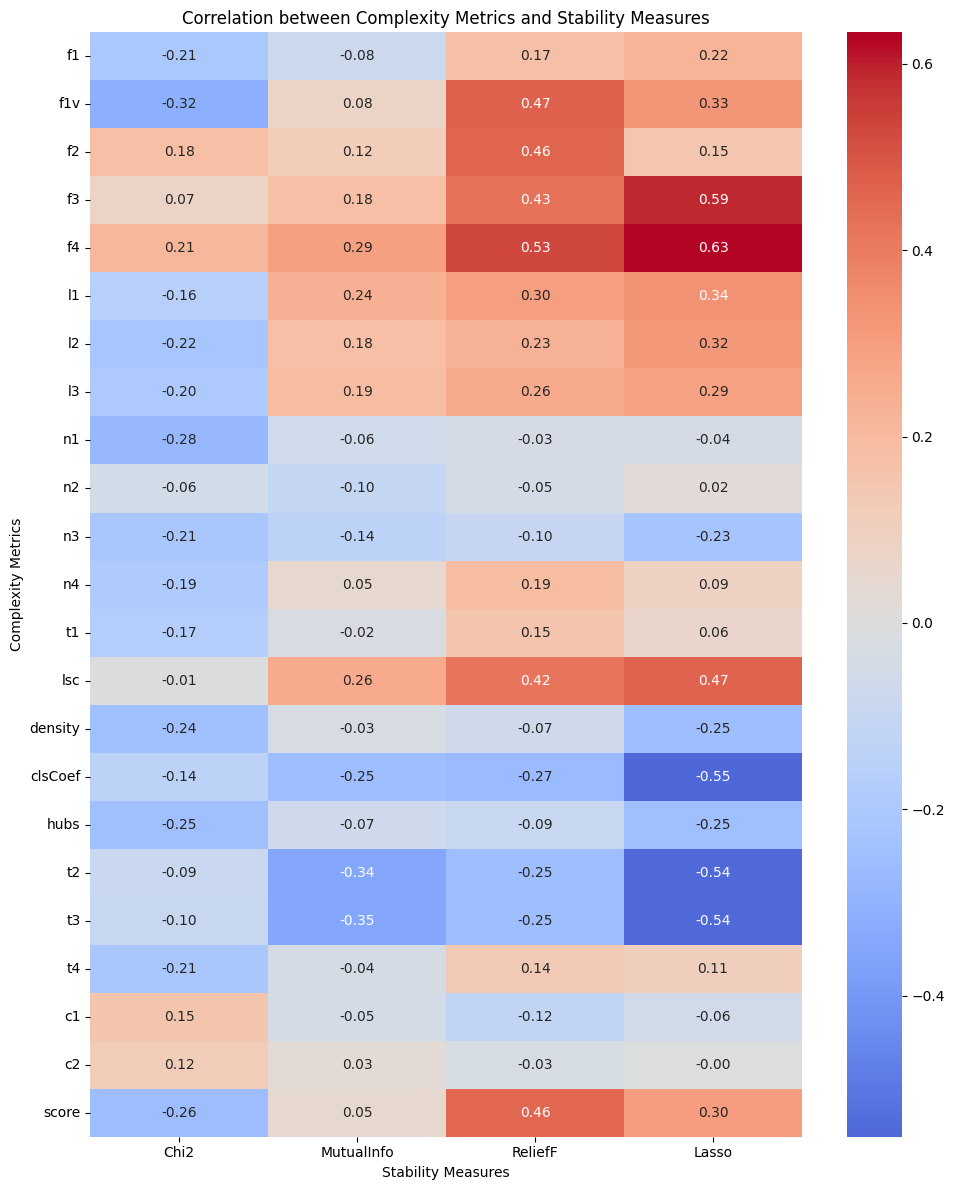

In [35]:
# Analyzing Correlation Between Dataset Complexity Metrics and Feature Selection Stability
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Read the CSV file (adjust the file path as needed)
file_path = "../data/results/originaldata-results/merged_complexity_and_stability.csv"
df = pd.read_csv(file_path)

# 2. Define complexity and stability columns
complexity_cols = ['f1', 'f1v', 'f2', 'f3', 'f4', 'l1', 'l2', 'l3', 
                   'n1', 'n2', 'n3', 'n4', 't1', 'lsc', 'density', 
                   'clsCoef', 'hubs', 't2', 't3', 't4', 'c1', 'c2', 'score']

stability_cols = ['Chi2', 'MutualInfo', 'ReliefF', 'Lasso']

# 3. Keep only relevant columns for analysis
sub_df = df[complexity_cols + stability_cols]

# 4. Compute Pearson correlation matrix between complexity metrics and each stability method
correlation_df = sub_df[complexity_cols].corrwith(sub_df[stability_cols[0]])
for col in stability_cols[1:]:
    correlation_df = pd.concat([correlation_df, sub_df[complexity_cols].corrwith(sub_df[col])], axis=1)

correlation_df.columns = stability_cols

# 5. Save the correlation results to CSV
output_path = "../data/results/originaldata-results/correlation_complexity_vs_stability.csv"
correlation_df.round(3).to_csv(output_path)

# 6. Print the correlation table
print("Pearson Correlation Table (Complexity vs Stability):")
print(correlation_df.round(3))

# 7. Draw a heatmap to visualize the correlations
plt.figure(figsize=(10, 12))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation between Complexity Metrics and Stability Measures")
plt.ylabel("Complexity Metrics")
plt.xlabel("Stability Measures")
plt.tight_layout()
plt.show()


## Feature Importance Mean with Random Forest

In [14]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

# Configuration
dataset_folder = "../data/original-datasets"  # Folder containing the datasets
output_csv_path = "../data/results/originaldata-results/summary_feature_importance_mean.csv"
features = ['CC', 'LCOM5', 'WMC', 'CBO', 'RFC', 'DIT', 'NOC', 'LOC', 'NPM']
target = 'isExistBug'
n_iter = 30
random_state = None

# List to hold mean importances for all projects
importance_summary = []

# Loop through all project files
for filename in os.listdir(dataset_folder):
    if filename.endswith(".csv"):
        project_name = os.path.splitext(filename)[0]
        file_path = os.path.join(dataset_folder, filename)
        print(f"Processing: {project_name}")

        # Load dataset
        df = pd.read_csv(file_path)
        X = df[features]
        y = LabelEncoder().fit_transform(df[target])

        # Perform stratified sampling
        splitter = StratifiedShuffleSplit(n_splits=n_iter, test_size=0.3, random_state=random_state)
        all_importances = []

        for train_idx, _ in splitter.split(X, y):
            X_train = X.iloc[train_idx]
            y_train = y[train_idx]

            rf = RandomForestClassifier(n_estimators=100, random_state=random_state)
            rf.fit(X_train, y_train)
            all_importances.append(rf.feature_importances_)

        # Calculate mean importances
        mean_importance = np.mean(all_importances, axis=0)

        # Store results by project name
        row = {"project_name": project_name}
        for i, feat in enumerate(features):
            row[feat] = round(mean_importance[i], 6)

        importance_summary.append(row)

# Convert to DataFrame
df_result = pd.DataFrame(importance_summary)
df_result = df_result[["project_name"] + features]

# Save to CSV
os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
df_result.to_csv(output_csv_path, index=False)

print("\nImportance mean summary saved to:", output_csv_path)


Processing: BugPrediction_Eclipse
Processing: BugPrediction_Equinox
Processing: BugPrediction_lucene
Processing: BugPrediction_Mylyn
Processing: BugPrediction_PDE
Processing: Github_Android
Processing: Github_antlr4
Processing: Github_BroadleafCommerce
Processing: Github_ceylon
Processing: Github_Elasticsearch
Processing: Github_hazelcast
Processing: Github_JUnit
Processing: Github_mapdb
Processing: Github_mcMMO
Processing: Github_mct17
Processing: Github_Neo4j
Processing: Github_Netty
Processing: Github_orientdb
Processing: Github_oryx
Processing: Github_titan
Processing: Promise_ant14
Processing: Promise_camel16
Processing: Promise_ckjm18
Processing: Promise_forrest08
Processing: Promise_ivy20
Processing: Promise_jedit43
Processing: Promise_log4j
Processing: Promise_lucene24
Processing: Promise_pbeans2
Processing: Promise_poi30
Processing: Promise_synapse12
Processing: Promise_velocity16
Processing: Promise_xalan27
Processing: Promise_xerces

Importance mean summary saved to: ../data

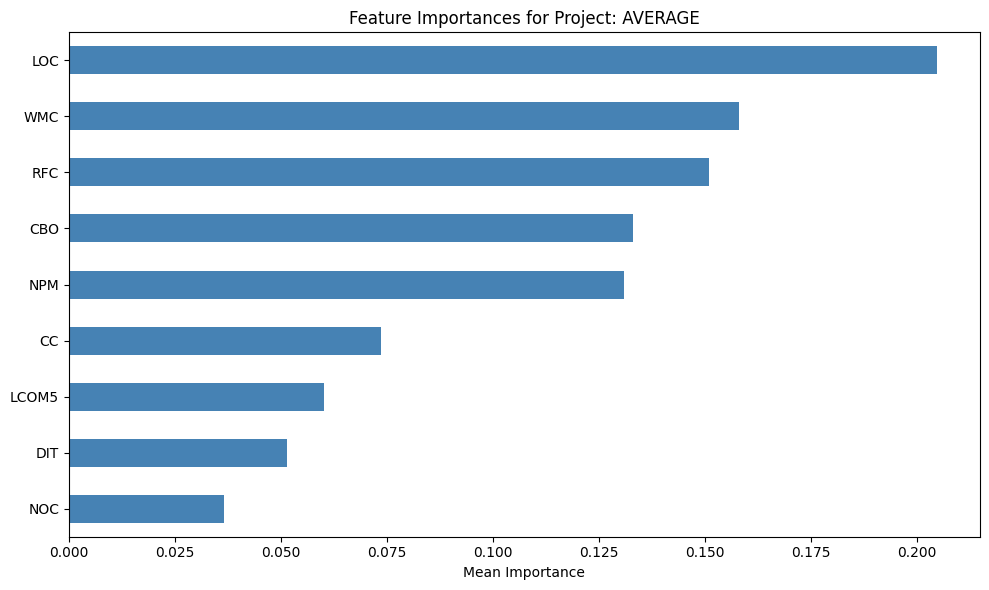

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to the CSV file
file_path = "../data/results/originaldata-results/summary_feature_importance_mean.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Set 'project_name' column as the index
df.set_index("project_name", inplace=True)

# Specify the project to visualize (e.g., use "AVERAGE" for average importances)
project_name = "AVERAGE"  # Replace with any project name you want to visualize
importance_values = df.loc[project_name].sort_values()

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
importance_values.plot(kind='barh', color='steelblue')
plt.xlabel("Mean Importance")
plt.title(f"Feature Importances for Project: {project_name}")
plt.tight_layout()
plt.show()


In [28]:
## Selected Features: LOC, WMC, RFC, CBO, NPM

## Filtered Dataset

In [15]:
import pandas as pd
import os

# Folder path
dataset_path = '../data/filtered-datasets'

# Required columns
required_columns = ['WMC', 'CBO', 'RFC', 'LOC', 'NPM', 'isExistBug']

# List to collect all valid DataFrames
df_list = []

# Iterate through all CSV files in the folder
for filename in os.listdir(dataset_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(dataset_path, filename)
        try:
            df = pd.read_csv(file_path)

            # Check if all required columns are present
            if all(col in df.columns for col in required_columns):
                # Extract project name from the filename (without extension)
                project_name = os.path.splitext(filename)[0]
                df = df[required_columns].copy()  # Keep only required columns
                df['project'] = project_name      # Add project name as a column
                df_list.append(df)
            else:
                print(f"Missing required columns: {filename}")
        except Exception as e:
            print(f"Error while reading file: {filename} | {e}")

# If at least one file was loaded successfully, concatenate them
if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)
    print(f"Total number of rows: {len(combined_df)}")
    print(combined_df.head())
else:
    print("No valid file found. Please check the files and column names.")


Total number of rows: 37630
   WMC  CBO  RFC  LOC  NPM  isExistBug                project
0   18    4   20  243   13           0  BugPrediction_Eclipse
1    5    1    5   71    5           0  BugPrediction_Eclipse
2   16    6   11   59    3           0  BugPrediction_Eclipse
3   14    3   11  308   10           0  BugPrediction_Eclipse
4    2    0    2   27    2           0  BugPrediction_Eclipse


## Computation Dataset Complexity Metrics

In [16]:
# Batch Computation and Export of Dataset Complexity Metrics for Multiple Projects

import os
import pandas as pd
from problexity import ComplexityCalculator
from sklearn.preprocessing import LabelEncoder

# Input and output folder paths
input_folder = "../data/filtered-datasets/"
output_folder = "../data/filtereddata-complexitymetrics/"

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Get all project names by removing .csv extension
project_names = [
    os.path.splitext(filename)[0]
    for filename in os.listdir(input_folder)
    if filename.endswith(".csv")
]

# Process each project
for project_name in project_names:
    input_file = os.path.join(input_folder, f"{project_name}.csv")
    output_file = os.path.join(output_folder, f"CM_{project_name}.csv")

    if not os.path.exists(output_file):
        print(f"Calculating metrics for {project_name}...")

        try:
            # Read dataset
            df = pd.read_csv(input_file)

            # Separate features and target
            X = df.drop(columns=["isExistBug"]).astype(float)
            y = LabelEncoder().fit_transform(df["isExistBug"])

            # Compute complexity metrics
            cc = ComplexityCalculator()
            cc.fit(X, y)
            report = cc.report()
            metrics = report["complexities"]
            metrics["score"] = report["score"]

            # Convert to DataFrame
            df_metrics = pd.DataFrame([metrics])
            df_metrics.insert(0, "project_name", project_name)

            # Save to CSV
            df_metrics.to_csv(output_file, index=False)
            print(f"{output_file} created successfully.")
        
        except Exception as e:
            print(f"Error processing {project_name}: {e}")
    
    else:
        print(f"{output_file} already exists. Skipping.")
        

Calculating metrics for BugPrediction_Eclipse...
../data/filtereddata-complexitymetrics/CM_BugPrediction_Eclipse.csv created successfully.
Calculating metrics for BugPrediction_Equinox...
../data/filtereddata-complexitymetrics/CM_BugPrediction_Equinox.csv created successfully.
Calculating metrics for BugPrediction_lucene...
../data/filtereddata-complexitymetrics/CM_BugPrediction_lucene.csv created successfully.
Calculating metrics for BugPrediction_Mylyn...
../data/filtereddata-complexitymetrics/CM_BugPrediction_Mylyn.csv created successfully.
Calculating metrics for BugPrediction_PDE...
../data/filtereddata-complexitymetrics/CM_BugPrediction_PDE.csv created successfully.
Calculating metrics for Github_Android...
../data/filtereddata-complexitymetrics/CM_Github_Android.csv created successfully.
Calculating metrics for Github_antlr4...
../data/filtereddata-complexitymetrics/CM_Github_antlr4.csv created successfully.
Calculating metrics for Github_BroadleafCommerce...
../data/filtereddat

## Merge Complexity Metrics

In [17]:
# Merging Project-Level Complexity Metric Files into a Single CSV
import os
import pandas as pd

# Input folder and output file path
input_folder = "../data/filtereddata-complexitymetrics/"
output_folder = "../data/results/filtereddata-results/"
output_file = os.path.join(output_folder, "merged_complexity_metrics.csv")

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Initialize an empty list
df_list = []

# Read all CSV files in the input folder that start with "CM_"
for filename in os.listdir(input_folder):
    if filename.startswith("CM_") and filename.endswith(".csv"):
        filepath = os.path.join(input_folder, filename)
        df = pd.read_csv(filepath)
        df_list.append(df)

# Concatenate all dataframes
merged_df = pd.concat(df_list, ignore_index=True)

# Save the merged dataframe to CSV
merged_df.to_csv(output_file, index=False)
print(f"All complexity metrics merged into: {output_file}")

All complexity metrics merged into: ../data/results/filtereddata-results/merged_complexity_metrics.csv


## Feature Selection Stability Metrics

In [19]:
# Automated Feature Selection and Stability Evaluation Across Multiple Projects
import os
import sys
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from skrebate import ReliefF
from sklearn.model_selection import StratifiedShuffleSplit
import random

# Add 'stability' module to path
sys.path.append(os.path.abspath('stability'))
import stability as st

# Folder configuration
dataset_folder = "../data/filtered-datasets"
output_dir = "../data/filtereddata-fs-stability-metrics"
os.makedirs(output_dir, exist_ok=True)

# Feature and target definitions
features = ['WMC', 'CBO', 'RFC', 'LOC', 'NPM']
target = 'isExistBug'

# Feature selection parameters
k = 2
n_iter = 30
random_state = None

# Helper function: convert feature selection results to binary matrix
def fs_result_to_binary_matrix(fs_result_list, all_features):
    return np.array([[1 if feat in selected else 0 for feat in all_features] for selected in fs_result_list])

# Process each CSV file
for filename in os.listdir(dataset_folder):
    if filename.endswith(".csv"):
        project_name = os.path.splitext(filename)[0]
        file_path = os.path.join(dataset_folder, filename)

        print(f"\nProcessing project: {project_name}")

        # 1. Load dataset
        df = pd.read_csv(file_path)
        X = df[features]
        y = LabelEncoder().fit_transform(df[target])

        splitter = StratifiedShuffleSplit(n_splits=n_iter, test_size=0.3, random_state=random_state)
        fs_results = {method: [] for method in ["Chi2", "MutualInfo", "ReliefF", "Lasso"]}

        # 2. Perform feature selection
        for _, (train_idx, _) in enumerate(splitter.split(X, y), start=1):
            X_sample = X.iloc[train_idx]
            y_sample = y[train_idx]

            # Chi2
            chi2_selector = SelectKBest(score_func=chi2, k=k)
            chi2_selector.fit(X_sample, y_sample)
            fs_results["Chi2"].append(X_sample.columns[chi2_selector.get_support()].tolist())

            # Mutual Info
            mi_selector = SelectKBest(score_func=mutual_info_classif, k=k)
            mi_selector.fit(X_sample, y_sample)
            fs_results["MutualInfo"].append(X_sample.columns[mi_selector.get_support()].tolist())

            # ReliefF
            relief_selector = ReliefF(n_features_to_select=k)
            relief_selector.fit(X_sample.values.astype(float), y_sample)
            top_relief = relief_selector.top_features_[:k]
            fs_results["ReliefF"].append(X_sample.columns[top_relief].tolist())

            # Lasso
            lasso_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=random.randint(0, 9999))
            lasso_model.fit(X_sample, y_sample)
            lasso_features = X_sample.columns[lasso_model.coef_[0] != 0].tolist()
            fs_results["Lasso"].append(lasso_features[:k] if len(lasso_features) > k else lasso_features)

        # 3. Save selected features to CSV (if not already exists)
        for method, results in fs_results.items():
            out_path = f"{output_dir}/{project_name}_{method}_selected_features.csv"
            if not os.path.exists(out_path):
                df_method = pd.DataFrame(results)
                df_method.index = [f"Run_{i+1}" for i in range(n_iter)]
                df_method.columns = [f"Feature_{j+1}" for j in range(df_method.shape[1])]
                df_method.insert(0, "Project", project_name)
                df_method.to_csv(out_path, index_label="Run")
            else:
                print(f"Skipped existing file: {out_path}")

        # 4. Compute stability scores and save to CSV (if not already exists)
        stab_path = f"{output_dir}/{project_name}_feature_selection_stability.csv"
        if not os.path.exists(stab_path):
            stability_records = []
            for method in fs_results:
                Z = fs_result_to_binary_matrix(fs_results[method], features)
                stab = st.getVarianceofStability(Z)
                ci = st.confidenceIntervals(Z)
                stability_records.append({
                    "Project": project_name,
                    "Method": method,
                    "Stability": round(stab['stability'], 4),
                    "CI_Lower": round(ci['lower'], 4),
                    "CI_Upper": round(ci['upper'], 4)
                })
            df_stability = pd.DataFrame(stability_records)
            df_stability.to_csv(stab_path, index=False)
        else:
            print(f"Skipped existing stability file: {stab_path}")

print("\nAll projects processed. Feature selection results and stability scores are saved.")



Processing project: BugPrediction_Eclipse

Processing project: BugPrediction_Equinox

Processing project: BugPrediction_lucene

Processing project: BugPrediction_Mylyn

Processing project: BugPrediction_PDE

Processing project: Github_Android

Processing project: Github_antlr4

Processing project: Github_BroadleafCommerce

Processing project: Github_ceylon

Processing project: Github_Elasticsearch

Processing project: Github_hazelcast

Processing project: Github_JUnit

Processing project: Github_mapdb


C:\Users\ramaz\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ramaz\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Processing project: Github_mcMMO

Processing project: Github_mct17

Processing project: Github_Neo4j

Processing project: Github_Netty

Processing project: Github_orientdb

Processing project: Github_oryx

Processing project: Github_titan

Processing project: Promise_ant14

Processing project: Promise_camel16

Processing project: Promise_ckjm18


C:\Users\ramaz\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ramaz\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Processing project: Promise_forrest08

Processing project: Promise_ivy20

Processing project: Promise_jedit43

Processing project: Promise_log4j

Processing project: Promise_lucene24

Processing project: Promise_pbeans2


C:\Users\ramaz\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Processing project: Promise_poi30

Processing project: Promise_synapse12

Processing project: Promise_velocity16

Processing project: Promise_xalan27


C:\Users\ramaz\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ramaz\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ramaz\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Processing project: Promise_xerces

All projects processed. Feature selection results and stability scores are saved.


## Merge Feature Selection Stability Metrics

In [20]:
# Merging and Pivoting Feature Selection Stability Reports with Custom Project Order
import os
import pandas as pd

# Input and output folders
input_folder = "../data/filtereddata-fs-stability-metrics"
output_folder = "../data/results/filtereddata-results"
os.makedirs(output_folder, exist_ok=True)

# Custom project order (defined manually)
custom_order = [
    "BugPrediction_Eclipse", "BugPrediction_Equinox", "BugPrediction_lucene", "BugPrediction_Mylyn",
    "BugPrediction_PDE", "Github_Android", "Github_antlr4", "Github_BroadleafCommerce", "Github_ceylon",
    "Github_Elasticsearch", "Github_hazelcast", "Github_JUnit", "Github_mapdb", "Github_mcMMO",
    "Github_mct17", "Github_Neo4j", "Github_Netty", "Github_orientdb", "Github_oryx", "Github_titan",
    "Promise_ant14", "Promise_camel16", "Promise_ckjm18", "Promise_forrest08", "Promise_ivy20",
    "Promise_jedit43", "Promise_log4j", "Promise_lucene24", "Promise_pbeans2", "Promise_poi30",
    "Promise_synapse12", "Promise_velocity16", "Promise_xalan27", "Promise_xerces"
]

# Read and merge all CSV files
df_list = []
for filename in sorted(os.listdir(input_folder)):
    if filename.endswith("_feature_selection_stability.csv"):
        file_path = os.path.join(input_folder, filename)
        df = pd.read_csv(file_path)
        df_list.append(df)

merged_df = pd.concat(df_list, ignore_index=True)

# Keep only needed columns
merged_df = merged_df[["Project", "Method", "Stability"]]

# Pivot: each method becomes a column
pivot_df = merged_df.pivot(index="Project", columns="Method", values="Stability").reset_index()

# Reorder method columns if needed
desired_order = ["Project", "Chi2", "MutualInfo", "ReliefF", "Lasso"]
pivot_df = pivot_df[desired_order]

# Sort rows by custom project order
pivot_df["Project"] = pd.Categorical(pivot_df["Project"], categories=custom_order, ordered=True)
pivot_df = pivot_df.sort_values("Project").reset_index(drop=True)

# Save result
output_path = os.path.join(output_folder, "merged_feature_selection_stability.csv")
pivot_df.to_csv(output_path, index=False)

print(f"Merged and ordered stability matrix saved to: {output_path}")


Merged and ordered stability matrix saved to: ../data/results/filtereddata-results\merged_feature_selection_stability.csv


## Merge Complexity Metrics and Stability Measures

In [21]:
import pandas as pd

# Load both CSV files
complexity_path = "../data/results/filtereddata-results/merged_complexity_metrics.csv"
stability_path = "../data/results/filtereddata-results/merged_feature_selection_stability.csv"

df_complexity = pd.read_csv(complexity_path)
df_stability = pd.read_csv(stability_path)

# Rename 'Project' column in stability to match 'project_name'
df_stability = df_stability.rename(columns={"Project": "project_name"})

# Merge on project_name
merged_df = pd.merge(df_complexity, df_stability, on="project_name", how="inner")

# Save to CSV
merged_output_path = "../data/results/filtereddata-results/merged_complexity_and_stability.csv"
merged_df.to_csv(merged_output_path, index=False)

print("Merged dataset saved to:", merged_output_path)


Merged dataset saved to: ../data/results/filtereddata-results/merged_complexity_and_stability.csv


## Correlation between Complexity Metrics and Stability Measures

Pearson Correlation Table (Complexity vs Stability):
          Chi2  MutualInfo  ReliefF  Lasso
f1       0.030       0.074    0.257  0.208
f1v     -0.034       0.232    0.308  0.139
f2       0.287       0.034    0.134  0.339
f3       0.291      -0.077    0.523  0.713
f4       0.400      -0.120    0.592  0.832
l1       0.341       0.106    0.317  0.445
l2       0.288       0.129    0.313  0.356
l3       0.368       0.164    0.377  0.381
n1      -0.007       0.005   -0.016 -0.088
n2      -0.177      -0.016    0.014 -0.012
n3      -0.185       0.035   -0.129 -0.333
n4       0.053       0.126    0.198 -0.028
t1       0.026      -0.020    0.117  0.020
lsc      0.228       0.051    0.550  0.568
density -0.279       0.380   -0.222 -0.516
clsCoef -0.533       0.194   -0.414 -0.794
hubs    -0.349       0.348   -0.232 -0.585
t2      -0.530       0.047   -0.400 -0.784
t3      -0.529       0.046   -0.404 -0.783
t4       0.088      -0.034   -0.102  0.148
c1      -0.044      -0.104   -0.134 -0.008
c

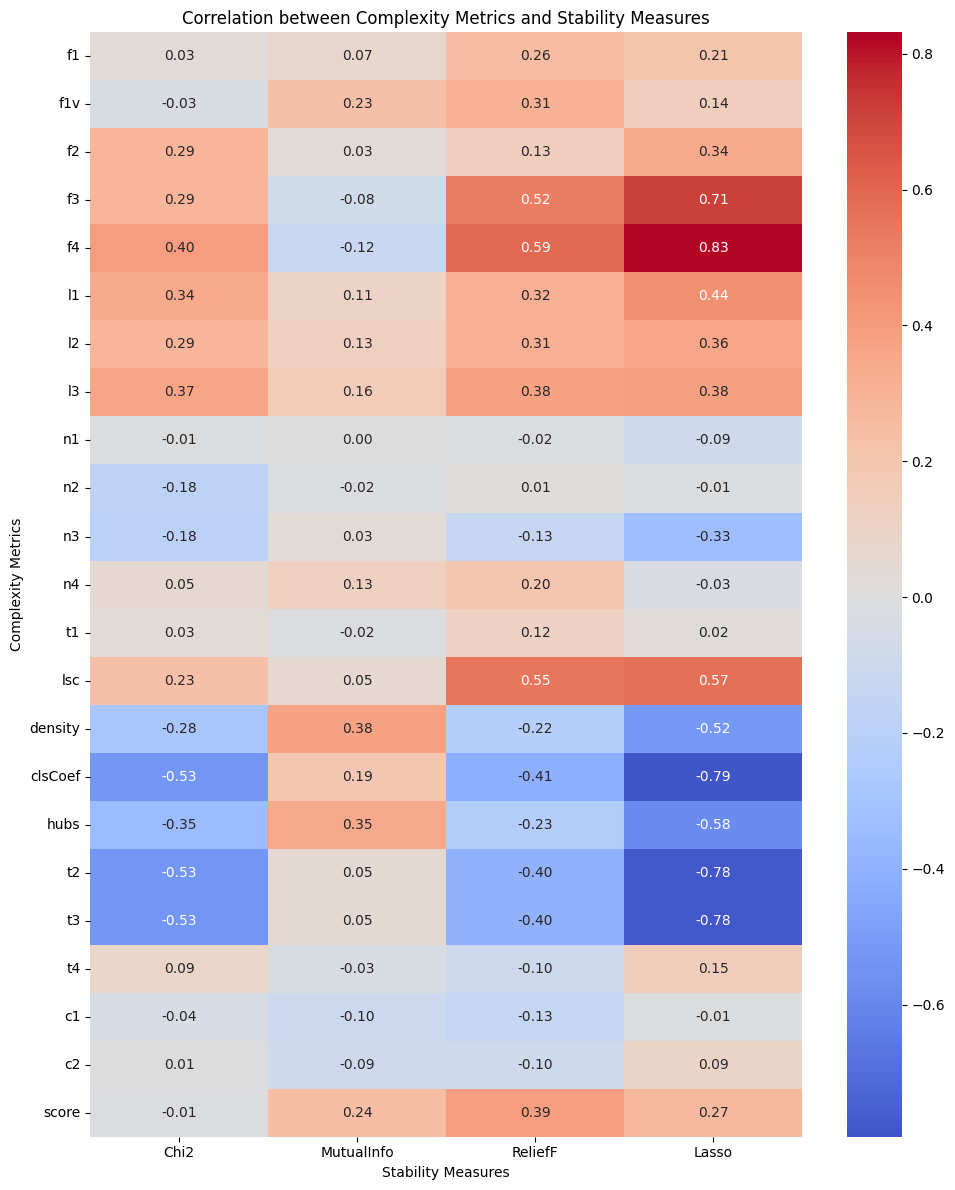

In [30]:
# Analyzing Correlation Between Dataset Complexity Metrics and Feature Selection Stability
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Read the CSV file (update the path according to your system)
file_path = "../data/results/filtereddata-results/merged_complexity_and_stability.csv"
df = pd.read_csv(file_path)

# 2. Define complexity and stability columns
complexity_cols = ['f1', 'f1v', 'f2', 'f3', 'f4', 'l1', 'l2', 'l3', 
                   'n1', 'n2', 'n3', 'n4', 't1', 'lsc', 'density', 
                   'clsCoef', 'hubs', 't2', 't3', 't4', 'c1', 'c2', 'score']

stability_cols = ['Chi2', 'MutualInfo', 'ReliefF', 'Lasso']

# 3. Extract only the required columns
sub_df = df[complexity_cols + stability_cols]

# 4. Compute the correlation matrix between complexity and stability measures
correlation_df = sub_df[complexity_cols].corrwith(sub_df[stability_cols[0]])
for col in stability_cols[1:]:
    correlation_df = pd.concat([correlation_df, sub_df[complexity_cols].corrwith(sub_df[col])], axis=1)

correlation_df.columns = stability_cols

# 5. Print the Pearson correlation table
print("Pearson Correlation Table (Complexity vs Stability):")
print(correlation_df.round(3))

# 6. Draw the heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation between Complexity Metrics and Stability Measures")
plt.ylabel("Complexity Metrics")
plt.xlabel("Stability Measures")
plt.tight_layout()
plt.show()


## Correlation between Complexity Metrics and Stability Measures After Outlier Projects

Pearson Correlation Table (Outliers Removed):
          Chi2  MutualInfo  ReliefF  Lasso
f1       0.121       0.037    0.326  0.411
f1v      0.146       0.185    0.420  0.336
f2       0.275       0.060    0.114  0.285
f3       0.389      -0.080    0.576  0.693
f4       0.487      -0.121    0.630  0.826
l1       0.361       0.144    0.313  0.362
l2       0.309       0.153    0.310  0.290
l3       0.407       0.190    0.379  0.316
n1      -0.005       0.017   -0.033 -0.225
n2      -0.149      -0.056    0.055  0.161
n3      -0.220       0.052   -0.154 -0.494
n4       0.044       0.150    0.189 -0.144
t1       0.046      -0.012    0.114 -0.109
lsc      0.300       0.046    0.575  0.568
density -0.279       0.379   -0.219 -0.567
clsCoef -0.573       0.192   -0.416 -0.855
hubs    -0.366       0.351   -0.233 -0.652
t2      -0.584       0.051   -0.408 -0.868
t3      -0.582       0.049   -0.412 -0.867
t4       0.083      -0.028   -0.110  0.135
c1      -0.038      -0.130   -0.123  0.124
c2      

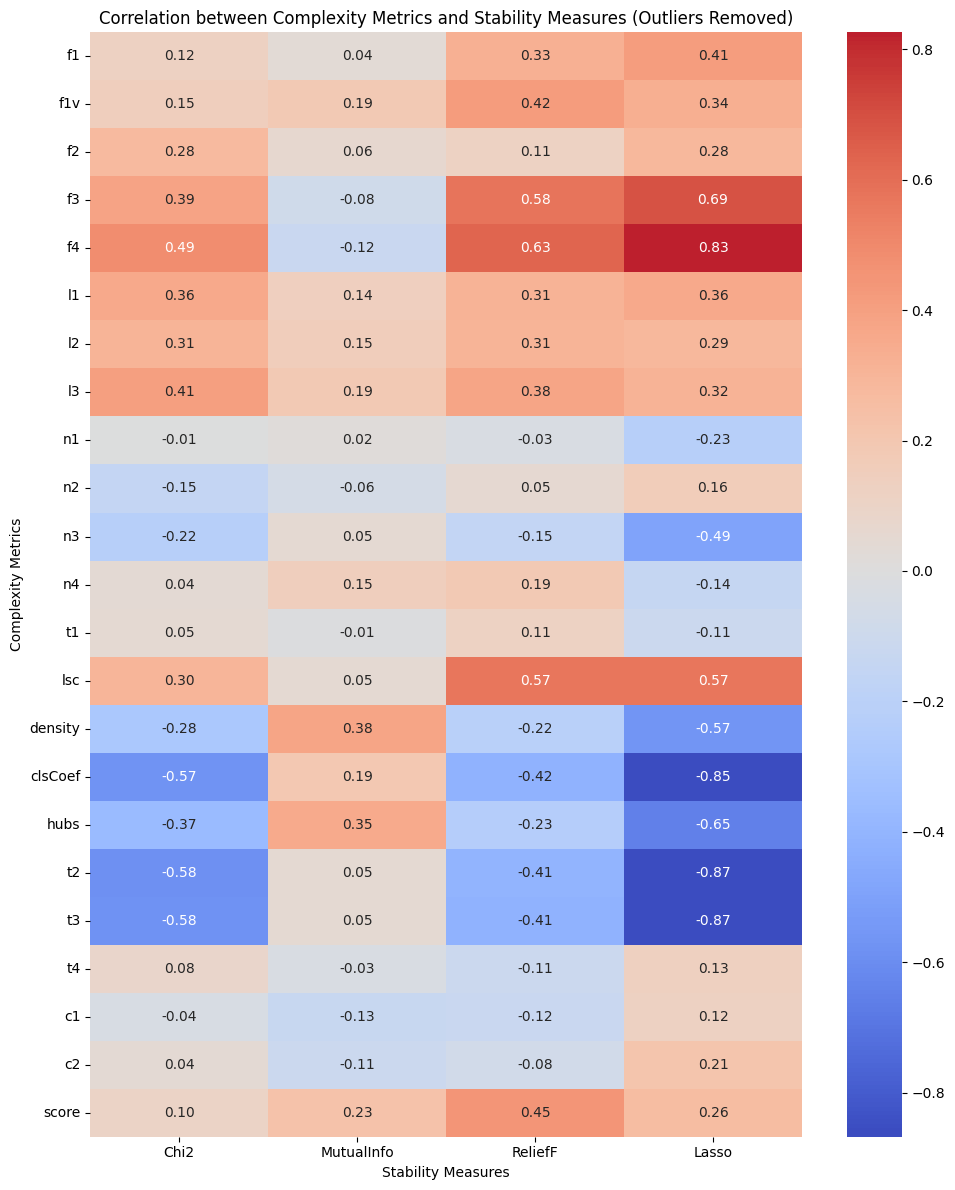

In [34]:
# Analyzing Correlation Between Dataset Complexity Metrics and Feature Selection Stability
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Read the CSV file (update the file path to match your environment)
file_path = "../data/results/filtereddata-results/merged_complexity_and_stability.csv"
df = pd.read_csv(file_path)

# 2. Remove outlier projects based on previously detected extreme bug rates
outliers = ["Promise_xalan27", "Promise_log4j"]
df = df[~df["project_name"].isin(outliers)]

# 3. Define the columns for complexity metrics and stability scores
complexity_cols = ['f1', 'f1v', 'f2', 'f3', 'f4', 'l1', 'l2', 'l3', 
                   'n1', 'n2', 'n3', 'n4', 't1', 'lsc', 'density', 
                   'clsCoef', 'hubs', 't2', 't3', 't4', 'c1', 'c2', 'score']

stability_cols = ['Chi2', 'MutualInfo', 'ReliefF', 'Lasso']

# 4. Keep only the relevant columns for correlation analysis
sub_df = df[complexity_cols + stability_cols]

# 5. Compute the Pearson correlation between complexity metrics and each stability method
correlation_df = sub_df[complexity_cols].corrwith(sub_df[stability_cols[0]])
for col in stability_cols[1:]:
    correlation_df = pd.concat([correlation_df, sub_df[complexity_cols].corrwith(sub_df[col])], axis=1)

correlation_df.columns = stability_cols

# 6. Save the correlation results to CSV
output_path = "../data/results/filtereddata-results/correlation_complexity_vs_stability.csv"
correlation_df.round(3).to_csv(output_path)

# 7. Print the resulting correlation table
print("Pearson Correlation Table (Outliers Removed):")
print(correlation_df.round(3))

# 8. Draw a heatmap to visualize the correlations
plt.figure(figsize=(10, 12))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation between Complexity Metrics and Stability Measures (Outliers Removed)")
plt.ylabel("Complexity Metrics")
plt.xlabel("Stability Measures")
plt.tight_layout()
plt.show()


Pearson Correlation (Complexity Metrics vs Bug Rate)
         Bug Rate Category
f1v         0.533     High
hubs        0.477     High
density     0.475     High
n4          0.401     High
n3          0.305   Medium
l2          0.301   Medium
n1          0.295   Medium
t1          0.277   Medium
l3          0.259   Medium
clsCoef     0.232   Medium
t2          0.190      Low
t3          0.186      Low
score       0.147      Low
l1          0.090      Low
f1          0.070      Low
lsc         0.045      Low
t4         -0.128      Low
n2         -0.129      Low
f3         -0.264   Medium
f4         -0.266   Medium
c1         -0.343   Medium
f2         -0.400   Medium
c2         -0.431     High


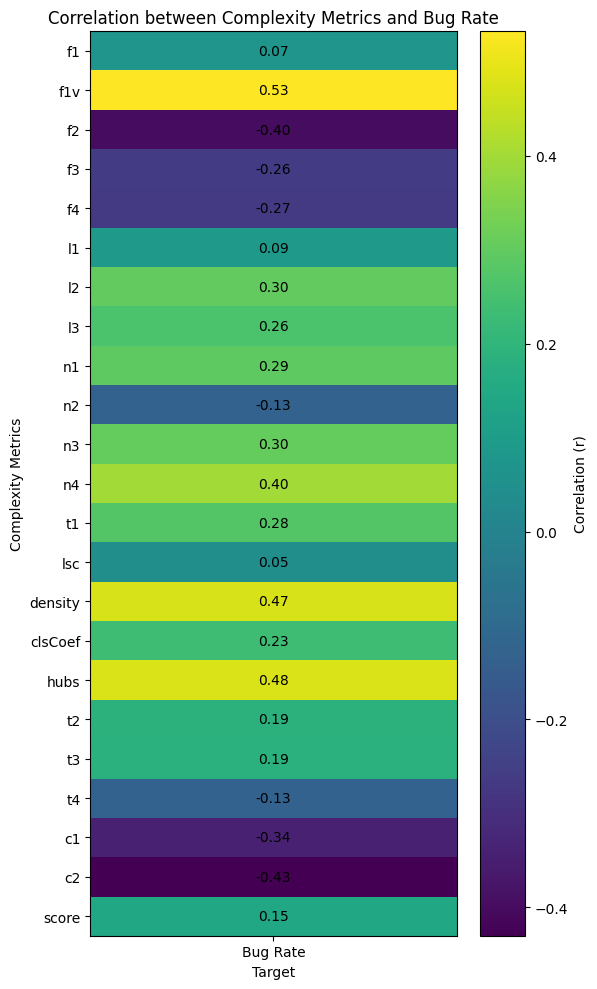

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load data
file_path = "../data/results/overall-results/merged_complexity_metrics_vs_bug_rate.csv"  # <- change if needed
df = pd.read_csv(file_path)

# 2) Pick complexity metrics (exclude identifiers/target)
complexity_cols = [c for c in df.columns if c not in ["project_name", "bug_rate"]]

# 3) Compute Pearson correlations with bug_rate
corr_series = df[complexity_cols].corrwith(df["bug_rate"])
corr_df = corr_series.to_frame(name="Bug Rate")

# 4) Categorize correlation strength
def categorize_corr(v: float) -> str:
    if abs(v) > 0.4:
        return "High"
    elif abs(v) >= 0.2:
        return "Medium"
    return "Low"

corr_df["Category"] = corr_df["Bug Rate"].apply(categorize_corr)

# 5) Print sorted table
corr_sorted = corr_df.sort_values(by="Bug Rate", ascending=False)
print("Pearson Correlation (Complexity Metrics vs Bug Rate)")
print(corr_sorted.round(3))

# 6) Plot heatmap with matplotlib only (single plot, no custom colors)
values = corr_df[["Bug Rate"]].values
fig, ax = plt.subplots(figsize=(6, 10))

im = ax.imshow(values, aspect="auto", interpolation="nearest")  # default colormap
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Correlation (r)", rotation=90)

# Axis labels and ticks
ax.set_xticks([0])
ax.set_xticklabels(["Bug Rate"])
ax.set_yticks(np.arange(len(corr_df.index)))
ax.set_yticklabels(corr_df.index)
ax.set_title("Correlation between Complexity Metrics and Bug Rate")
ax.set_xlabel("Target")
ax.set_ylabel("Complexity Metrics")

# Annotate cells with correlation values
for i in range(values.shape[0]):
    ax.text(0, i, f"{values[i,0]:.2f}", ha="center", va="center")

plt.tight_layout()
# plt.savefig("complexity_vs_bugrate_heatmap.png", dpi=300)  # optional
plt.show()
